In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt

# Microbiome profile

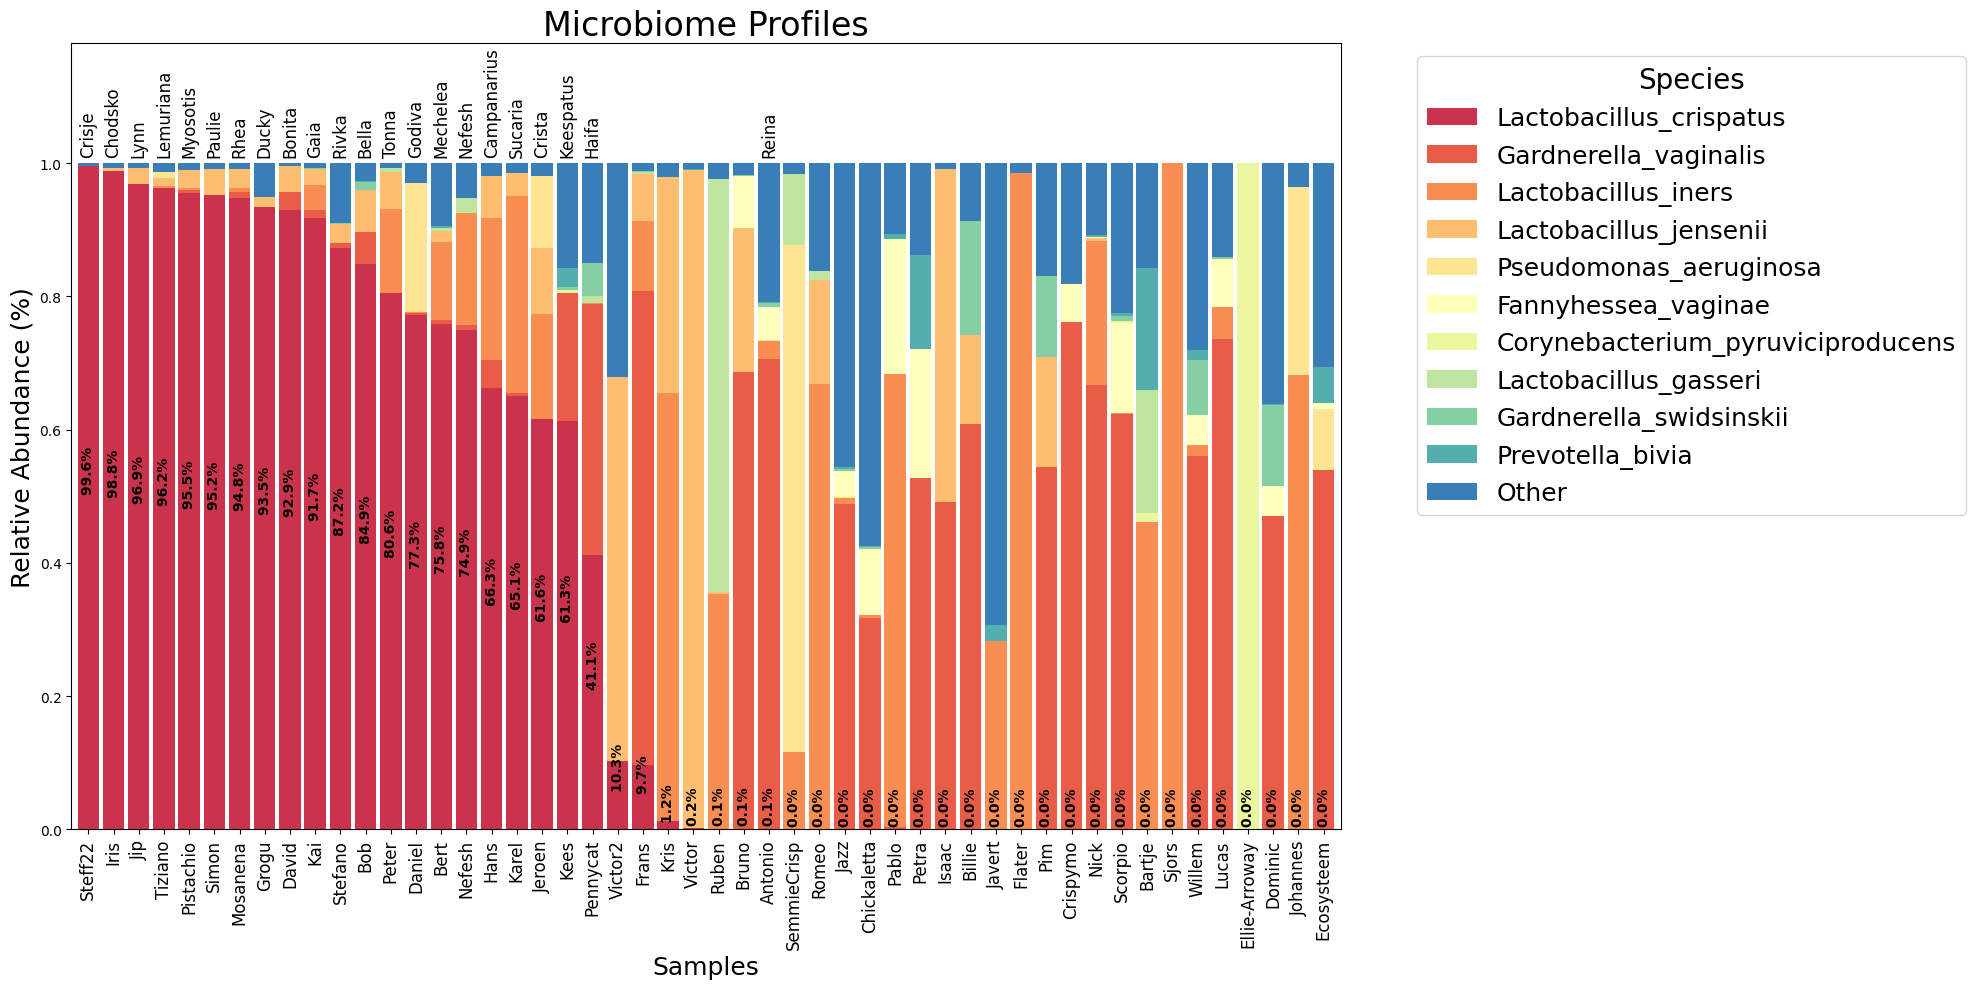

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random

# Load the Excel file
sample_name_table = pd.read_csv("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/metagenome_sample_names.tsv", 
                                sep="\t", index_col="metagenome_name")
data = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/bacteria_abundance_normalized.xlsx")

# Remove the 's__' prefix from species names in 'ln_species'
data["ln_species"] = data["ln_species"].str.replace("^s__", "", regex=True)

# Extract sample names from the first row (excluding 'ln_species') and extract species names and their abundances
sample_names = data.columns[1:]
species = data["ln_species"]
abundance_data = data.groupby("ln_species", sort=False).sum()

# Compute the average relative abundance for each species across all samples, identify top species by abundance and add "Other" category
average_abundance = abundance_data.mean(axis=1)
top_species = average_abundance.nlargest(10).index.tolist()
other_abundance = abundance_data.loc[~abundance_data.index.isin(top_species)].sum()
filtered_data = abundance_data.loc[top_species]
filtered_data.loc["Other"] = other_abundance

# some data transformations for the heatmap to ensure Lactobacillus crispatus is at the bottom of the stacked bar chart
filtered_data = filtered_data.T  # Samples as rows, species as columns
filtered_data = filtered_data[["Lactobacillus_crispatus"] + [col for col in filtered_data.columns if col != "Lactobacillus_crispatus"]]
filtered_data.sort_values(by="Lactobacillus_crispatus", ascending=False, inplace=True)

# Plot stacked bar chart with L. crispatus at the bottom
fig, ax = plt.subplots(figsize=(20, 10))
colors = sns.color_palette("Spectral", n_colors=len(filtered_data.columns))
filtered_data.plot(kind="bar", stacked=True, color=colors, width=0.85, ax=ax)

# Annotate percentages of L. crispatus in each bar and make sure they do not overlap (in height) by adding a value depending on the previous y-value
last_n = 0
crispatus_dict = {}
for idx, sample in enumerate(filtered_data.index):
    crispatus_value = filtered_data.loc[sample, "Lactobacillus_crispatus"] * 100
    crispatus_name = sample_name_table.loc[sample].values[0]
    if crispatus_name == "Not applicable": crispatus_name = ""
    ax.text(idx, 1.01, f"{crispatus_name}", fontsize=12, ha="center", va="bottom", rotation=90)
    
    if crispatus_value < 0.1: prevent_overlap = 0.01
    else: prevent_overlap = 0.01
    ax.text(idx, 
            crispatus_value / 2 / 100 + prevent_overlap, 
            f"{crispatus_value:.1f}% ", fontsize=10, fontweight="bold", ha="center", rotation=90)
    crispatus_dict[sample] = filtered_data.loc[sample, "Lactobacillus_crispatus"] # == crispatus_value / 100

# Customize the plot
plt.xlabel("Samples", fontsize=18)
plt.ylabel("Relative Abundance (%)", fontsize=18)
plt.title("Microbiome Profiles", fontsize=24)
plt.legend(title="Species", title_fontsize=20, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=18)
plt.xticks(ticks=range(len(filtered_data.index)), labels=filtered_data.index, fontsize=12)
plt.ylim(0, 1.18)
plt.tight_layout()

# Save and show the plot
output_plot = "/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/microbiome_profile_plot.png"
plt.savefig(output_plot)
plt.show()

# print(f"Microbiome profile plot saved to {output_plot}")


# Functional categories and microbiome profile correlation

ValueError: too many values to unpack (expected 2)

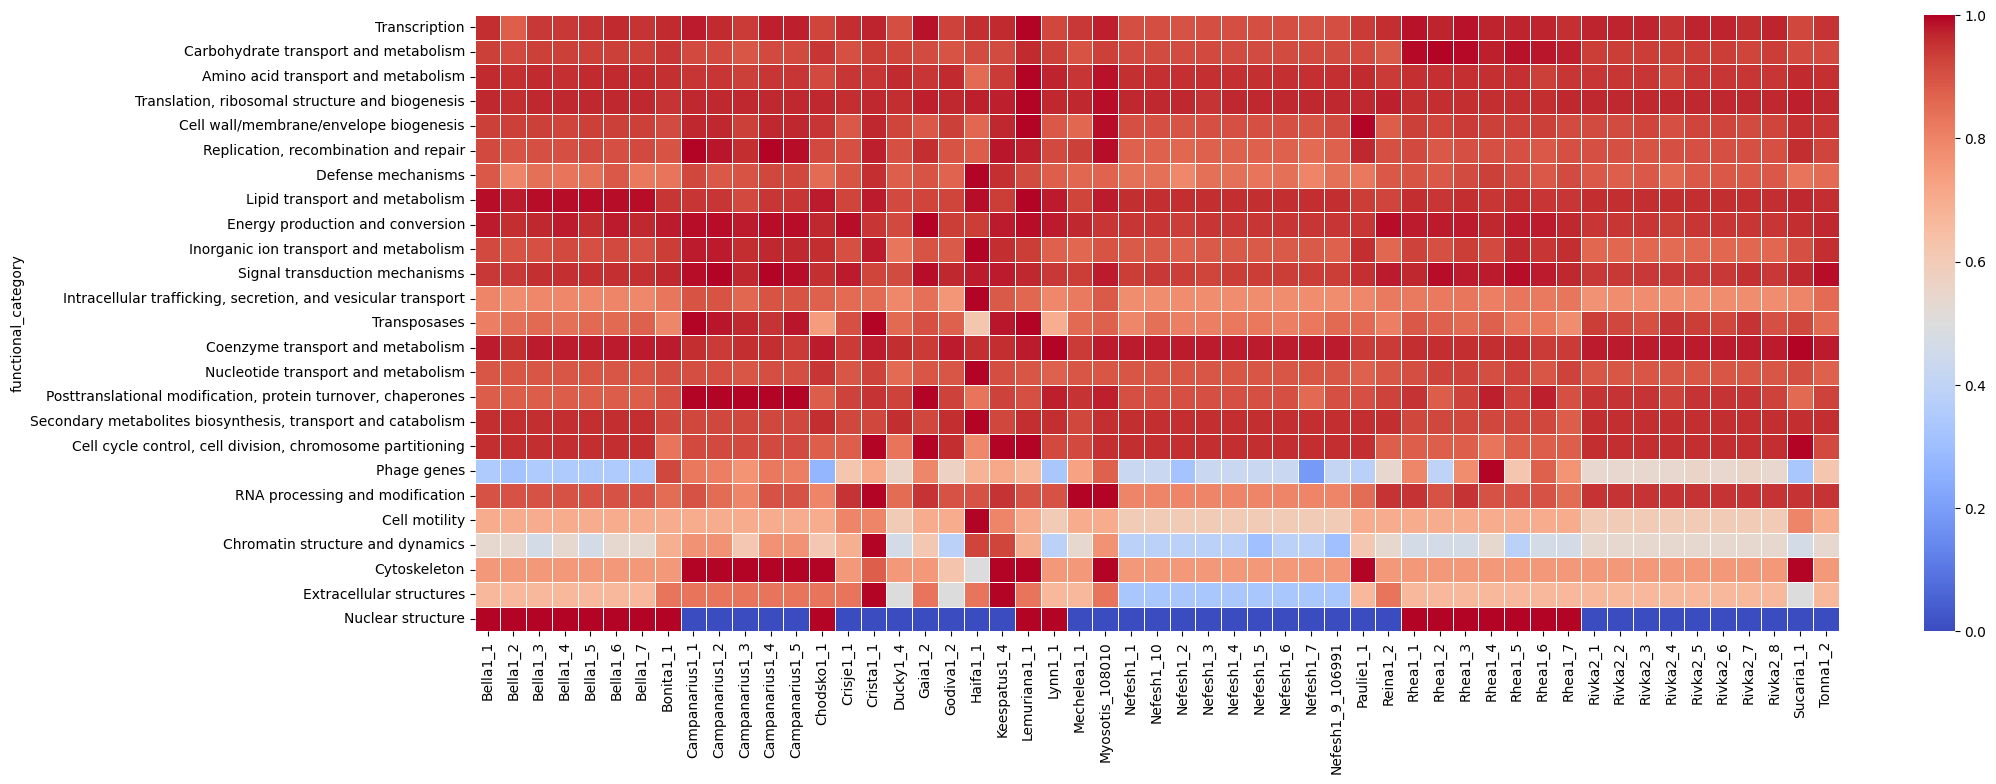

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

merged_gene_data = pd.read_excel("../results/pangenome_results/intra_individual/pandavis/COG_matched_gene_families_func_only.xlsx")
sample_columns = merged_gene_data.columns[merged_gene_data.columns.get_loc('Bella1_1'):merged_gene_data.columns.get_loc('Tonna1_2') + 1]
functional_group_totals = merged_gene_data.groupby('functional_category')[sample_columns].count()


plt.figure(figsize=(22, 8))
df_prophage = functional_group_totals
df_prophage_sorted = df_prophage.sort_values(by=df_prophage.columns[0], ascending=False)
df_prophage_n = df_prophage_sorted.div(df_prophage_sorted.max(axis=1), axis=0) # normalize rows
sns.heatmap(df_prophage_n, cmap="coolwarm", annot=False, fmt=".0f", linewidths=.5)

for idx, func_group in df_prophage_sorted.index:
    ax.text(23, idx, df_prophage_sorted[idx])

plt.title("Functional group counts", fontsize=16)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Functional category", fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()

# Save and show the heatmap
# plt.savefig(f"../results/pangenome_results/intra_individual/figures/functional_group_mge_heatmap_all_n.png")

display(df_prophage_n)

In [4]:
from scipy.stats import spearmanr

# Convert metagenome names to crispatus names (if they have one, else just keep the metagenome name)
mapping_names = pd.read_csv("../data/metagenome/metagenome_sample_names.tsv", sep="\t")
crispatus_names_dict = {(sample_name if sample_name != "Not applicable" else meta_name): crispatus_dict[meta_name] for meta_name, sample_name in zip(mapping_names["metagenome_name"], mapping_names["crispatus_name"]) if meta_name in crispatus_dict}

# Add crispatus abundances to correct sample names (_1, _2, etc)
crispatus_abundance = pd.DataFrame() 
for name in df_prophage_n.columns:
    for k, v in crispatus_names_dict.items():
        if k in name:
            crispatus_abundance.loc[name, "crispatus_abundance"] = v
            break

# Extract sample prefixes to group related samplesand calculate the mean for functional groups and crispatus abundance
crispatus_abundance["group"] = crispatus_abundance["group"] = crispatus_abundance.index.str.split("_").str[0]
functional_group_totals = df_prophage_n.T
functional_group_totals["group"] = functional_group_totals.index.str.split("_").str[0]
# display(functional_group_totals)
grouped_abundance = crispatus_abundance.groupby("group")["crispatus_abundance"].mean()
grouped_functional_groups = (
    functional_group_totals
    .groupby("group")  # Group by "group" along the row axis
    .mean(numeric_only=True)  # Use numeric_only=True to ignore non-numeric columns like "group"
)
# grouped_functional_groups.reset_index(inplace=True)

# Calculate Spearman correlation for each functional category
correlations = []
p_values = []

for category in grouped_functional_groups.columns:
    if category == 'group':
        continue
    corr, p_val = spearmanr(grouped_abundance, grouped_functional_groups.loc[:, category])
    correlations.append(corr)
    p_values.append(p_val)

# Compile results into a DataFrame
results = pd.DataFrame({
    "Functional_category": grouped_functional_groups.columns,
    "Spearman_correlation": correlations,
    "P_value": p_values
})
display(results)
# Save results to CSV
# results_file = "/path/to/spearman_results.csv"  # Replace with your desired output path
# results.to_csv(results_file, index=False)

,Functional_category,Spearman_correlation,P_value
0,Transcription,0.023190,0.918411
1,Carbohydrate transport and metabolism,0.499011,0.018070
2,Amino acid transport and metabolism,0.454554,0.033559
3,"Translation, ribosomal structure and biogenesis",-0.274273,0.216750
4,Cell wall/membrane/envelope biogenesis,0.138653,0.538314
5,"Replication, recombination and repair",0.041879,0.853194
6,Defense mechanisms,-0.216629,0.332877
7,Lipid transport and metabolism,0.082126,0.716356
8,Energy production and conversion,0.177023,0.430638
9,Inorganic ion transport and metabolism,-0.145126,0.519321


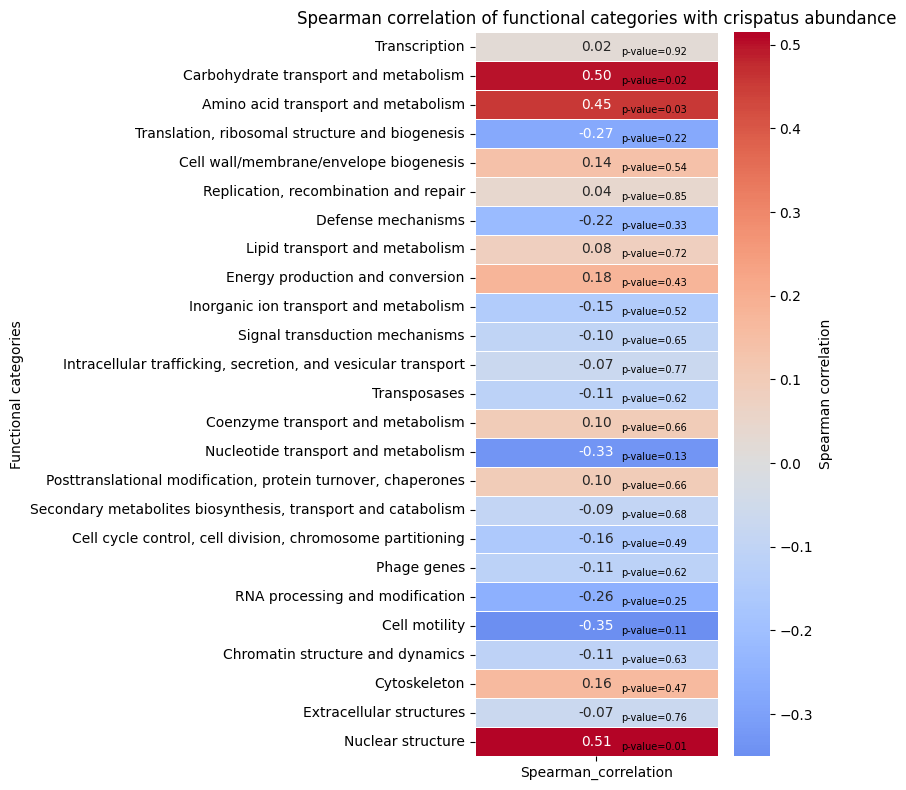

In [5]:
heatmap_data = results.set_index("Functional_category")[["Spearman_correlation"]]

# Create a heatmap
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Spearman correlation"},
    fmt=".2f",
)

for idx, p_value in enumerate(results.P_value):
    ax.text(0.6, idx+0.5, f"p-value={round(p_value, 2)}", fontsize=7, va="top")

plt.title("Spearman correlation of functional categories with crispatus abundance")
plt.xlabel("")
plt.ylabel("Functional categories")
plt.tight_layout()
plt.savefig("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/data/metagenome/corr_abundance_func_groups.png")
plt.show()

# Bacteriocins

In [6]:
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df_bacteriocins = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/bacteriocin/bacteriocin_table.xlsx")
df_bacteriocins[["Sample", "Class"]].groupby(["Sample"]).agg(['count', 'nunique'])

Class        
                 count nunique
Sample                        
Bella1_1             8       5
Bella1_2             6       4
Bella1_3             8       5
Bella1_4             6       3
Bella1_5             7       4
Bella1_6             8       5
Bella1_7             7       4
Bonita1_1            5       5
Campanarius1_1       5       4
Campanarius1_2       5       4
Campanarius1_3       5       4
Campanarius1_4       5       4
Campanarius1_5       5       4
Chodsko1_1           5       4
Crisje1_1            5       4
Crista1_1            7       5
Ducky1_4             6       5
Gaia1_2              5       4
Godiva1_2            8       5
Haifa1_1            11       7
Keespatus1_4         6       5
Lemuriana1_1         8       5
Lynn1_1              7       5
Mechelea1_1          6       4
Myosotis_108010      7       5
Nefesh1-9_106991     8       6
Nefesh1_1            8       6
Nefesh1_10           8       6
Nefesh1_2            7       5
Nefesh1_3            8       6
Nefesh1_4            8       6
Nefesh1_5            8       6
Nefesh1_6            8       6
Nefesh1_7            8       6
Paulie1_1            9       6
Reina1_2             6       4
Rhea1_1              5       5
Rhea1_2              6       5
Rhea1_3              5       5
Rhea1_4              6       5
Rhea1_5              5       5
Rhea1_6              5       4
Rhea1_7              3       3
Rivka2_1             9       6
Rivka2_2             9       6
Rivka2_3             9       6
Rivka2_4             9       6
Rivka2_5             9       5
Rivka2_6             9       6
Rivka2_7             9       6
Rivka2_8             9       6
Sucaria1_1           8       6
Tonna1_1             5       4

In [8]:
df_bacteriocins["Class"].unique()

array(['Penocin_A', 'Enterolysin_A', 'Bacteriocin_helveticin_J',
       'Helveticin-J', 'SakT_alpha', 'Helveticin',
       'Lanthipeptide_class_I', 'LAPs', 'putative_bacteriocin',
       'CoagulinA', 'Amylovorin'], dtype=object)

In [9]:
df_bacteriocins[["Sample", "I", "IIa", "IIb", "III", "Unknown"]].groupby(["Sample"]).agg("sum")

,I,IIa,IIb,III,Unknown
Sample,,,,,
Bella1_1,0,1,1,5,0
Bella1_2,0,1,0,4,0
Bella1_3,0,1,1,5,0
Bella1_4,0,0,0,5,0
Bella1_5,0,1,0,5,0
Bella1_6,0,1,1,5,0
Bella1_7,0,1,0,5,0
Bonita1_1,1,0,1,2,0
Campanarius1_1,0,1,0,3,0


# CRISPR-Cas

In [10]:
import pandas as pd
import numpy as np
df_crispr = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/crisprcas/HMM2019_cassettes_freek.xlsx")
df_crispr["sample_name"] = df_crispr["sample"].str.extract(r'^([^_]+_[^_]+)')
# df_crispr

## Subtypes

In [11]:
df_pred = pd.read_csv("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/crisprcas/predictions.csv", index_col="cassette_id")
# df_pred

In [12]:
df_crispr_merged = df_crispr.set_index("cassette_id").join(df_pred)
# display(df_crispr_merged)
crispr_predictions = np.sort(df_crispr_merged["predicted_label"].unique())

for prediction in crispr_predictions:
    df_crispr_merged[prediction] = df_crispr_merged['sample_name'].apply(
        lambda x: 1 if prediction in df_crispr_merged[df_crispr_merged['sample_name'] == x]['predicted_label'].values else 0
    )
# display(df_crispr_merged)

In [13]:
# display(df_crispr_merged.reset_index())
crispr_pred_result = df_crispr_merged.reset_index().drop_duplicates(subset=["cassette_id", "predicted_label", "sample_name"])
crispr_pred_result = df_crispr_merged.reset_index().drop_duplicates("sample_name")
crispr_pred_result.shape # CAS-I-E	CAS-II-A	CAS-II-C	CAS-V-A	CAS-V-F	CAS-VI-B	CAS-VI-C
# crispr_pred_result.to_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/crisprcas/crisprcas_results_subtypes.xlsx")

(53, 19)

In [14]:
crispr_sum = crispr_pred_result[["CAS-I-E", "CAS-II-A", "CAS-II-C", "CAS-V-A", "CAS-V-F", "CAS-VI-B", "CAS-VI-C"]].sum(axis=1)

corr, p_val = spearmanr(crispr_sum, functional_group_totals.loc[:, "Phage genes"])
print(corr, p_val)

-0.23585934139420253 0.08909005690810064


# Summary statistics

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_overview_full = pd.read_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence_v2.xlsx')
uniques = df_overview_full.apply(lambda x: x.nunique())
df_overview = df_overview_full.drop(uniques[uniques==1].index, axis=1)

# Define the dependent variable (target) and independent variables (features)
target = 'Abundance'
features = df_overview.columns.difference(['Sample name', target])

In [46]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# Calculate Spearman correlation between each feature and the target
correlations = {}
for feature in features:
    corr, p_value = spearmanr(df_overview[feature], df_overview[target])
    correlations[feature] = {'Spearman Rho': corr, 'p-value': p_value}  # p_value*len(features)

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Spearman Rho', ascending=False)
p_values = correlation_df["p-value"]
_, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh')
print(p_adjusted)
print(correlation_df)


[0.12413554 0.13373916 0.61763416 0.50847227 0.43100498 0.13373916
 0.13373916 0.13373916 0.12501199 0.04023425 0.03751485 0.02978663]
                                 Spearman Rho   p-value
Bacteriocin class IIb                0.281201  0.041379
CAS-V-F                              0.228188  0.100304
GTA                                 -0.070160  0.617634
GT1, GT2 & GTB                      -0.102290  0.466100
Bacteriocin class I                 -0.128493  0.359171
CAS-I-E                             -0.228188  0.100304
CAS-VI-C                            -0.228188  0.100304
MucBP domain-containing protein     -0.230368  0.097012
Glycogen growth prediction          -0.268293  0.052088
Plasmid                             -0.350600  0.010059
Bacteriocin class IIa               -0.370921  0.006252
CAS-II-C                            -0.407126  0.002482


In [40]:
merged_gene_data = pd.read_excel("../results/pangenome_results/intra_individual/pandavis/COG_matched_gene_families_func_only.xlsx")
sample_columns = merged_gene_data.columns[merged_gene_data.columns.get_loc('Bella1_1'):merged_gene_data.columns.get_loc('Tonna1_2') + 1]
functional_group_totals = merged_gene_data.groupby('functional_category')[sample_columns].count().T  #.drop(
#     ["Bella1_2", 'Bella1_3', 'Bella1_4', 'Bella1_5', 'Bella1_6', 'Bella1_7', 'Nefesh1_2', 'Nefesh1_3', 'Nefesh1_4', 'Nefesh1_5', 
#      'Nefesh1_6', 'Nefesh1_7', 'Nefesh1_9_106991', 'Nefesh1_10', 'Campanarius1_2', 'Campanarius1_3', 'Campanarius1_4', 'Campanarius1_5',
#      'Rhea1_2', 'Rhea1_3', 'Rhea1_4', 'Rhea1_5', 'Rhea1_6', 'Rhea1_7', 'Rivka2_2', 'Rivka2_3', 'Rivka2_4', 'Rivka2_5', 'Rivka2_6', 'Rivka2_7', 'Rivka2_8'])
# df_overview.set_index("Sample name", inplace=True)
# df_overview = df_overview.drop(["Bella1_2", 'Bella1_3', 'Bella1_4', 'Bella1_5', 'Bella1_6', 'Bella1_7', 'Nefesh1_2', 'Nefesh1_3', 'Nefesh1_4', 'Nefesh1_5', 
#      'Nefesh1_6', 'Nefesh1_7', 'Nefesh1-9_106991', 'Nefesh1_10', 'Campanarius1_2', 'Campanarius1_3', 'Campanarius1_4', 'Campanarius1_5',
#      'Rhea1_2', 'Rhea1_3', 'Rhea1_4', 'Rhea1_5', 'Rhea1_6', 'Rhea1_7', 'Rivka2_2', 'Rivka2_3', 'Rivka2_4', 'Rivka2_5', 'Rivka2_6', 'Rivka2_7', 'Rivka2_8'])

correlations = {}
for feature in features:
    corr, p_value = spearmanr(df_overview[feature], functional_group_totals["Phage genes"])
    correlations[feature] = {'Spearman Rho': corr, 'p-value': p_value}  # p_value*len(features)

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Spearman Rho', ascending=False)
print(correlation_df)

                                 Spearman Rho   p-value
Glycogen growth prediction           0.440657  0.000959
Bacteriocin class I                  0.249443  0.071661
CAS-II-C                             0.145503  0.298543
Bacteriocin class IIa                0.072414  0.606352
MucBP domain-containing protein      0.025756  0.854748
CAS-V-F                              0.018183  0.897177
Plasmid                              0.003295  0.981321
CAS-I-E                             -0.018183  0.897177
CAS-VI-C                            -0.018183  0.897177
Bacteriocin class IIb               -0.112586  0.422176
GTA                                 -0.364391  0.007308
GT1, GT2 & GTB                      -0.380212  0.004981


GT fragmenten lijken significant, wanneer intra invidu samples gegroepeerd zijn alleen GTA significant (0.041710 < 0.05), andere GT fragmenten = 0.058126. Redelijk sterke negatieve correlation (~-0.67)


                Spearman Rho   p-value
GTA                -0.364391  0.007308
GT1, GT2 & GTB     -0.380212  0.004981


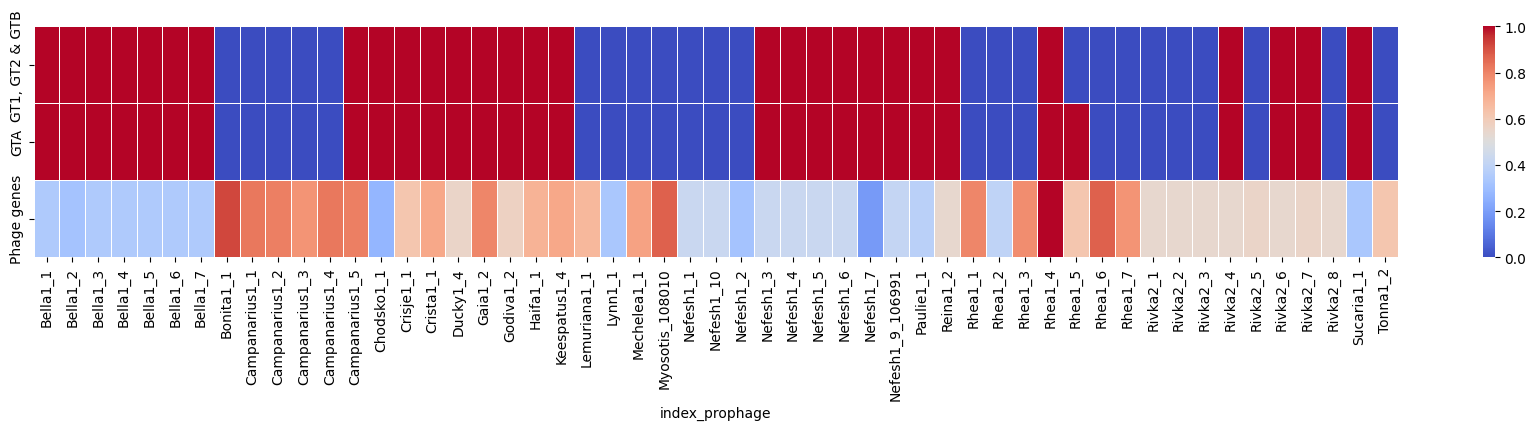

In [18]:
df1 = df_overview[['GT1, GT2 & GTB', 'GTA']].reset_index()
df2 = functional_group_totals['Phage genes'].reset_index()
# display(df1)
# display(df2)

df_prophage = df1.join(df2, lsuffix='_gt', rsuffix='_prophage').drop('index_gt', axis=1).set_index('index_prophage').T
df_prophage_norm = df_prophage.div(df_prophage.max(axis=1), axis=0)
# display(df_prophage)

plt.figure(figsize=(22, 3))
sns.heatmap(df_prophage_norm, cmap="coolwarm", annot=False, fmt=".0f", linewidths=.5)

# Spearman correlation between all GT fragments and Phage genes
df_prophage_T = df_prophage.T
phage_features = ['GT1, GT2 & GTB', 'GTA']
correlations = {}
for feature in phage_features:
    corr, p_value = spearmanr(df_prophage_T[feature], df_prophage_T["Phage genes"])
    correlations[feature] = {'Spearman Rho': corr, 'p-value': p_value}  # p_value*len(features)

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Spearman Rho', ascending=False)
print(correlation_df)

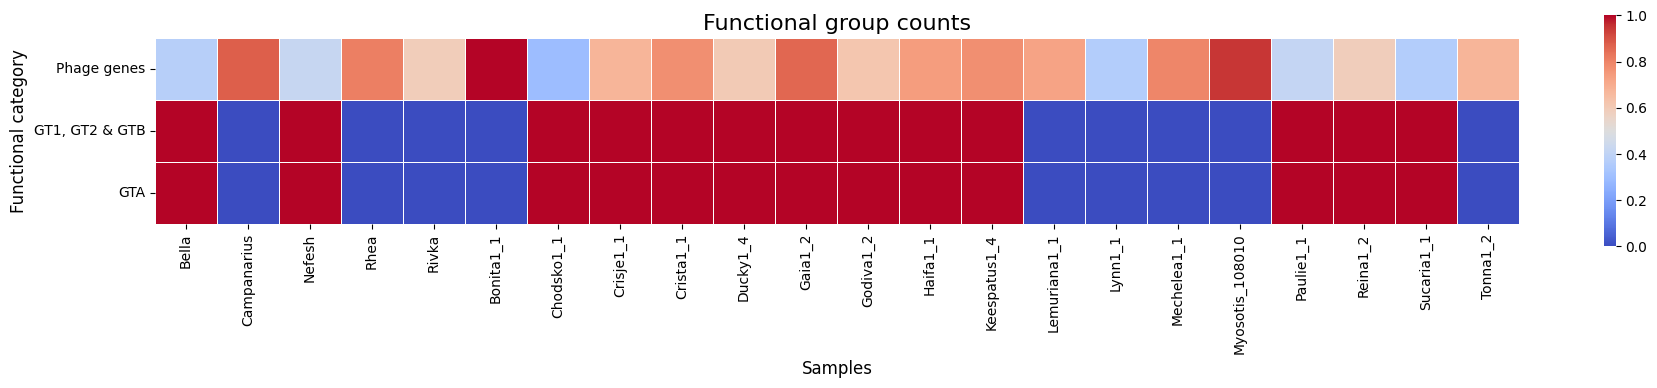

                Spearman Rho   p-value
GT1, GT2 & GTB     -0.430243  0.045643
GTA                -0.430243  0.045643


In [19]:
"""
Group the intra individual samples before doing a Spearman rank correlation test to avoid inflating the numbers. 
Majority vote for GT fragments and mean of Phage genes
"""

from scipy.stats import spearmanr

intra_individuals = ["Bella", "Campanarius", "Nefesh", "Rhea", "Rivka"]
grouped_results = {}

# Process intra-individuals by calculating majority and mean
for prefix in intra_individuals:
    # Filter columns that match the prefix
    group_df = df_prophage.filter(regex=f"^{prefix}")
    
    # Calculate the majority value for GT1, GTA, and GTB
    majority_values = group_df.loc[['GT1, GT2 & GTB', 'GTA']].mode(axis=1)[0]
    
    # Calculate the mean for Phage genes
    phage_mean = group_df.loc["Phage genes"].mean()
    
    # Combine results
    grouped_results[prefix] = pd.Series(
        data=list(majority_values) + [phage_mean],
        index=['GT1, GT2 & GTB', 'GTA', "Phage genes"]
    )

# Add columns for individuals not in intra-individuals without modification
for col in df_prophage.columns:
    if not any(col.startswith(prefix) for prefix in intra_individuals):
        grouped_results[col] = df_prophage[col]
# Convert the results to a DataFrame for better readability
grouped_summary_df = pd.DataFrame(grouped_results)

# display(grouped_summary_df.T)
plt.figure(figsize=(22, 3))
grouped_summary_df_sorted = grouped_summary_df.sort_values(by=grouped_summary_df.columns[0], ascending=False)
grouped_df_n = grouped_summary_df_sorted.div(grouped_summary_df_sorted.max(axis=1), axis=0) 
sns.heatmap(grouped_df_n, cmap="coolwarm", linewidths=.5, square=True)
plt.title("Functional group counts", fontsize=16)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Functional category", fontsize=12)
# plt.tight_layout()
plt.show()

# Spearman correlation between all GT fragments and Phage genes
df_prophage_T = grouped_summary_df.T
phage_features = ['GT1, GT2 & GTB', 'GTA']
correlations = {}
for feature in phage_features:
    corr, p_value = spearmanr(df_prophage_T[feature], df_prophage_T["Phage genes"])
    correlations[feature] = {'Spearman Rho': corr, 'p-value': p_value}  # p_value*len(features)

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Spearman Rho', ascending=False)
print(correlation_df)

<Axes: >

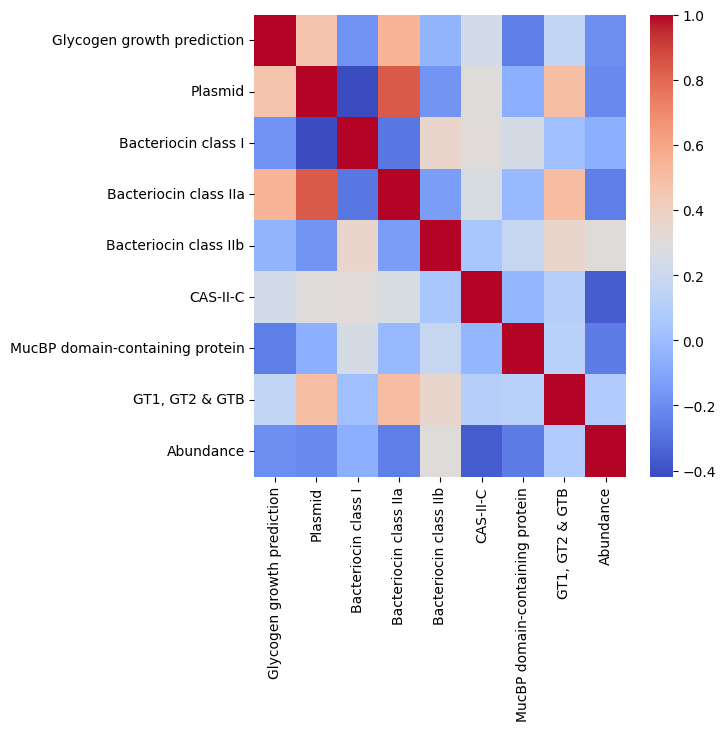

In [27]:
df_overview_full = pd.read_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence_v2.xlsx')
uniques = df_overview_full.apply(lambda x: x.nunique())
df_overview = df_overview_full.drop(uniques[uniques==1].index, axis=1).drop(["Sample name", "CAS-I-E", "CAS-V-F", "CAS-VI-C", "GTA"], axis=1)

fig, ax = plt.subplots(figsize=(6,6))
# display(df_overview)
sns.heatmap(df_overview.corr(), cmap="coolwarm")

In [26]:
import scipy

df_corr = pd.DataFrame()
feat1s = []
feat2s = []
corrs = []
p_values = []

for feat1 in df_overview.columns:
    for feat2 in df_overview.columns:
        # if feat1 != feat2:
        feat1s.append(feat1)
        feat2s.append(feat2)
        corr, p_value = scipy.stats.spearmanr(df_overview[feat1], df_overview[feat2])
        corrs.append(corr)
        p_values.append(p_value)
        if (p_value < 0.05 and corr > 0.4) or (p_value < 0.05 and corr < -0.4): 
            print(f"{feat1}, {feat2}: {corr}, {p_value}")

df_corr['Feature_1'] = feat1s
df_corr['Feature_2'] = feat2s
df_corr['Correlation'] = corrs
df_corr['p_value'] = p_values
display(df_corr)

df_corr[(df_corr["Feature_1"] == "Phage count") & (df_corr["Feature_2"] == "Phage count")]["p_value"].values

# df_corr.style.format({'p_value': '{:.2f}'})

Glycogen growth prediction, Glycogen growth prediction: 1.0, 0.0
Glycogen growth prediction, Bacteriocin class IIa: 0.4776894929029353, 0.00029789148426925675
Plasmid, Plasmid: 1.0, 0.0
Plasmid, Bacteriocin class I: -0.41843539934082624, 0.0018205569232759595
Plasmid, Bacteriocin class IIa: 0.8359806435340692, 6.7425939628836746e-15
Plasmid, GT1, GT2 & GTB: 0.49715097395971264, 0.0001525009019051094
Plasmid, GTA: 0.5165253323626364, 7.514526089740798e-05
Bacteriocin class I, Plasmid: -0.4184353993408263, 0.001820556923275956
Bacteriocin class I, Bacteriocin class I: 1.0, 0.0
Bacteriocin class IIa, Glycogen growth prediction: 0.4776894929029353, 0.00029789148426925675
Bacteriocin class IIa, Plasmid: 0.8359806435340692, 6.7425939628836746e-15
Bacteriocin class IIa, Bacteriocin class IIa: 1.0, 0.0
Bacteriocin class IIa, GT1, GT2 & GTB: 0.5041210646719653, 0.00011879944650873079
Bacteriocin class IIa, GTA: 0.5269037369525961, 5.0519032046511124e-05
Bacteriocin class IIb, Bacteriocin class 

,Feature_1,Feature_2,Correlation,p_value
0,Glycogen growth prediction,Glycogen growth prediction,1.000000,0.000000
1,Glycogen growth prediction,Plasmid,0.388428,0.004051
2,Glycogen growth prediction,Bacteriocin class I,-0.105535,0.451995
3,Glycogen growth prediction,Bacteriocin class IIa,0.477689,0.000298
4,Glycogen growth prediction,Bacteriocin class IIb,0.003638,0.979376
...,...,...,...,...
164,Abundance,CAS-VI-C,-0.228188,0.100304
165,Abundance,MucBP domain-containing protein,-0.230368,0.097012
166,Abundance,"GT1, GT2 & GTB",-0.102290,0.466100
167,Abundance,GTA,-0.070160,0.617634


array([], dtype=float64)

## Boxplots

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_overview_full = pd.read_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence_v2.xlsx')
uniques = df_overview_full.apply(lambda x: x.nunique())
df_overview_full = df_overview_full.drop(df_overview_full[(df_overview_full['Sample name'] == 'Haifa1_1')].index) # & (df_overview_full['Sample name'] =='Reina1_2')
df_overview = df_overview_full.drop(uniques[uniques==1].index, axis=1).drop(["Sample name", "CAS-I-E", "CAS-V-F", "CAS-VI-C"], axis=1)

features = df_overview.columns.difference(['Sample name', 'Abundance'])
# display(df_overview)

In [ ]:
for feature in features:
    sns.boxplot(data=df_overview, x=feature, y='Abundance')
    plt.show()

In [ ]:
for feature in features:
    Means = df_overview.groupby(feature)['Abundance'].mean()
    fig, ax = plt.subplots()
    sns.violinplot(data=df_overview, x=feature, y='Abundance', inner='quart', density_norm='count')
    # plt.setp(ax.collections, alpha=.3)
    plt.scatter(x=range(len(Means)),y=Means,c="r")
    plt.show()

In [ ]:
# Perform one-way ANOVA for each feature against 'Abundance'
anova_results = {}
for feature in features:
    groups = [df_overview[df_overview[feature] == value]['Abundance'] for value in df_overview[feature].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value}

# Convert results to a DataFrame for better visualization
anova_df = pd.DataFrame(anova_results).T
anova_df.sort_values(by='p-value', inplace=True)

# Print or save the results
print(anova_df)
anova_df.to_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/anova_results_v2.xlsx')

In [ ]:
for feature in features:
    groups = [df_overview[df_overview[feature] == value]['Abundance'] for value in df_overview[feature].unique()]
    if len(groups) != 2:
        continue
    median = df_overview.groupby(feature)['Abundance'].median()
    mean = df_overview.groupby(feature)['Abundance'].mean()
    # print(median)
    # print(mean)
    print(feature, *stats.mannwhitneyu(groups[0], groups[1]))
    # print('\n')

# Statistics high, medium and low abundance

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table.xlsx', skiprows=[0])
df.loc[df[df['Abundance'] >= 0.8].index, 'Abundance_group'] = 'high'
# df.loc[df[df['Abundance'] < 0.9].index, 'Abundance_group'] = 'medium'
df.loc[df[df['Abundance'] < 0.8].index, 'Abundance_group'] = 'low'

In [29]:
# df_grouped = df.groupby('Abundance_group').agg('nunique')
# display(df_grouped)
df_high = df[df['Abundance_group']=='high']

result_dict = {}
for col in df_high.columns:
    if col=='Sample name' or col=='Glycogen growth prediction indication': continue
    print(col)
    result_dict[col] = {}
    for index, value in df_high[col].value_counts().items():
        print(index, value)
        result_dict[col][index] = value
        # result_dict[f'{col}_{index}'] = value
        # result_dict[col][index] = value

Glycogen growth prediction
1.0 20
0.5 6
0.0 6
oriC
1 24
0 8
AR genes plasmid
0 32
Virulence genes plasmid
0 32
AR genes
0 32
Virulence genes
0 32
bacteriocins count
9 9
5 9
6 5
8 4
7 4
3 1
nunique
5 14
4 8
6 8
3 2
I
0 25
1 7
IIa
2 12
0 11
1 9
IIb
1 25
0 7
III
5 14
3 10
2 5
4 3
Unknown
0 32
CRISPR-Cas count
10 13
11 9
9 7
12 2
8 1
cas1
1 32
cas2
1 32
cas3
1 32
cas5
0 21
1 11
cas6
0 28
1 4
cas7
0 32
cas8
0 18
1 14
cas9
1 28
0 4
cas10
0 29
1 3
cas11
0 31
1 1
cas12
1 32
cmr5
0 31
1 1
csa3
1 30
0 2
cse2
0 32
csm2
0 32
csm6
0 32
csn2
1 32
csx1
0 32
csx3
1 32
csx19
0 31
1 1
csx21
0 25
1 7
DinG
1 32
Gram-positive cocci surface proteins LPxTG domain-containing protein
1 32
MucBP domain-containing protein
0 31
1 1
type IV pilus-like proteins
1 32
Putative adhesin domain-containing protein
1 32
GT1
1 18
0 14
GT2
1 18
0 14
GT3
0 32
GTA
1 19
0 13
GTB
1 18
0 14
UDP-galactopyra0semutase
0 32
Flippase
0 32
Abundance
0.8724173394652572 8
0.947578012512744 7
0.8487984881236701 7
0.9293416522690459 1
0.9

In [30]:
print(result_dict)
pd.DataFrame.from_dict(result_dict)
# display(df_high[df_high.columns].value_counts())
# df_high[df_high['Glycogen growth prediction']].value_counts().items().to_excel('/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/analysis/df_high.xlsx')

{'Glycogen growth prediction': {1.0: 20, 0.5: 6, 0.0: 6}, 'oriC': {1: 24, 0: 8}, 'AR genes plasmid': {0: 32}, 'Virulence genes plasmid': {0: 32}, 'AR genes': {0: 32}, 'Virulence genes': {0: 32}, 'bacteriocins count': {9: 9, 5: 9, 6: 5, 8: 4, 7: 4, 3: 1}, 'nunique': {5: 14, 4: 8, 6: 8, 3: 2}, 'I': {0: 25, 1: 7}, 'IIa': {2: 12, 0: 11, 1: 9}, 'IIb': {1: 25, 0: 7}, 'III': {5: 14, 3: 10, 2: 5, 4: 3}, 'Unknown': {0: 32}, 'CRISPR-Cas count': {10: 13, 11: 9, 9: 7, 12: 2, 8: 1}, 'cas1': {1: 32}, 'cas2': {1: 32}, 'cas3': {1: 32}, 'cas5': {0: 21, 1: 11}, 'cas6': {0: 28, 1: 4}, 'cas7': {0: 32}, 'cas8': {0: 18, 1: 14}, 'cas9': {1: 28, 0: 4}, 'cas10': {0: 29, 1: 3}, 'cas11': {0: 31, 1: 1}, 'cas12': {1: 32}, 'cmr5': {0: 31, 1: 1}, 'csa3': {1: 30, 0: 2}, 'cse2': {0: 32}, 'csm2': {0: 32}, 'csm6': {0: 32}, 'csn2': {1: 32}, 'csx1': {0: 32}, 'csx3': {1: 32}, 'csx19': {0: 31, 1: 1}, 'csx21': {0: 25, 1: 7}, 'DinG': {1: 32}, 'Gram-positive cocci surface proteins LPxTG domain-containing protein': {1: 32}, 'Mu

,Glycogen growth prediction,oriC,AR genes plasmid,Virulence genes plasmid,AR genes,Virulence genes,bacteriocins count,nunique,I,IIa,...,Putative adhesin domain-containing protein,GT1,GT2,GT3,GTA,GTB,UDP-galactopyra0semutase,Flippase,Abundance,Abundance_group
1.0,20.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,9.0,...,32.0,18.0,18.0,NaN,19.0,18.0,NaN,NaN,NaN,NaN
0.5,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,6.0,8.0,32.0,32.0,32.0,32.0,NaN,NaN,25.0,11.0,...,NaN,14.0,14.0,32.0,13.0,14.0,32.0,32.0,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,9.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,5.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# for col in df_grouped.columns:
#     sns.countplot(df_grouped[col].value_counts())
#     plt.show()

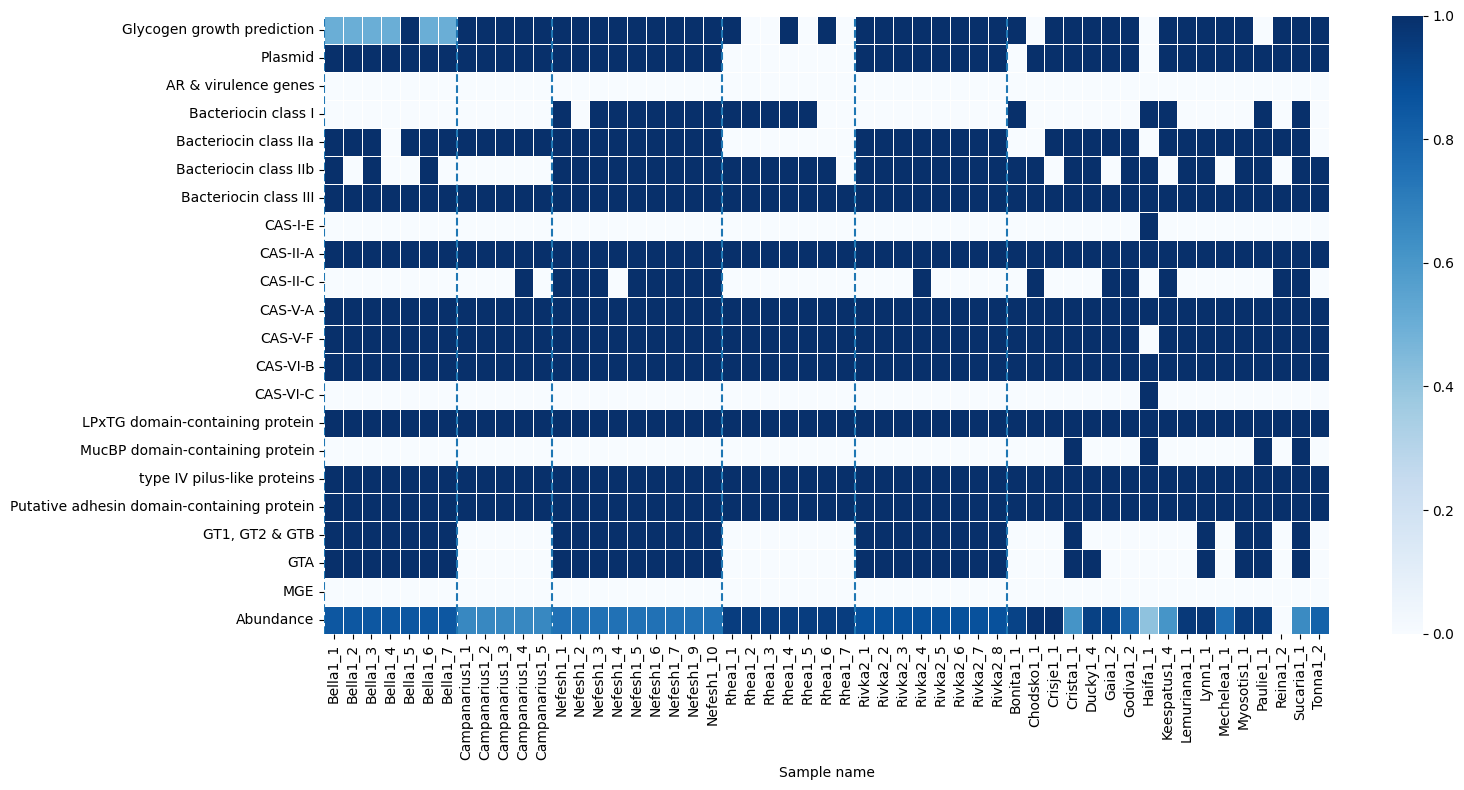

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# df_overview = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence.xlsx", index_col="Sample name")

# plt.figure(figsize=(16, 12))
# sns.heatmap(df_overview.T, linewidths=0.5, cmap="Blues")
# plt.show()

df_overview_2 = pd.read_excel("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_table_pres_absence_v2.xlsx", index_col="Sample name")

plt.figure(figsize=(16, 8))
ax = sns.heatmap(df_overview_2.T, linewidths=0.5, cmap="Blues")
ax.axvline(x=0, ls="--")
ax.axvline(x=7, ls="--")
ax.axvline(x=12, ls="--")
ax.axvline(x=21, ls="--")
ax.axvline(x=28, ls="--")
ax.axvline(x=36, ls="--")
plt.tight_layout()
plt.savefig("/mnt/c/users/freek/Documents/BioSb/Internship/PangenomeProject/results/probiotic_properties/overview_heatmap.png")